In [2]:
import geopandas as gpd
import rasterio
import rasterio.mask
from rasterio.mask import mask
from rasterio.merge import merge
from shapely.geometry import mapping, box
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from rasterio.plot import show
from pathlib import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
BASE = Path("/Users/hester/Desktop/data/OS digimap_terrain data/terrain")
WORLD_SHP = "/Users/hester/Desktop/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"

In [4]:
OUT_RES = 200

In [5]:
world = gpd.read_file(WORLD_SHP)
cols = set(world.columns)

if "ADM0_A3" in cols:
    uk = world[world["ADM0_A3"].astype(str).str.upper() == "GBR"]
elif "ISO_A3" in cols:
    uk = world[world["ISO_A3"].astype(str).str.upper() == "GBR"]
elif "ADMIN" in cols:
    uk = world[world["ADMIN"].astype(str).str.contains("United Kingdom", case=False, na=False)]
else:
    raise ValueError(f"Cannot find UK id column. Available columns: {list(world.columns)}")

if len(uk) == 0:
    raise ValueError("UK geometry not found in the shapefile. (GBR not matched)")

uk = uk.dissolve()

In [6]:
dem_files_all = sorted(BASE.rglob("*.asc"))
print("Total tiles:", len(dem_files_all))

Total tiles: 2800


In [7]:
with rasterio.open(dem_files_all[0]) as src0:
    raster_crs = src0.crs

uk = uk.to_crs(raster_crs)
uk["geometry"] = uk.geometry.buffer(0) 
uk_geom = uk.geometry.iloc[0]

In [8]:
minx, miny, maxx, maxy = uk_geom.bounds
uk_bbox_geom = box(minx, miny, maxx, maxy)

dem_files = []
for fp in dem_files_all:
    with rasterio.open(fp) as s:
        b = s.bounds
        tile_box = box(b.left, b.bottom, b.right, b.top)
        if tile_box.intersects(uk_bbox_geom):
            dem_files.append(fp)

print("Tiles intersecting UK bbox:", len(dem_files))

Tiles intersecting UK bbox: 2799


In [9]:
srcs = [rasterio.open(fp) for fp in dem_files]

mosaic, out_transform = merge(
    srcs,
    bounds=(minx, miny, maxx, maxy),   
    res=OUT_RES                   
)

for s in srcs:
    s.close()

In [10]:
meta = {
    "driver": "GTiff",
    "dtype": mosaic.dtype,
    "count": 1,
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "crs": raster_crs,
    "transform": out_transform,
    "nodata": None}

In [11]:
geoms = [mapping(uk_geom)]

with rasterio.io.MemoryFile() as memfile:
    with memfile.open(**meta) as ds:
        ds.write(mosaic)
        dem_masked, mask_transform = rasterio.mask.mask(
            ds, geoms, crop=True, nodata=np.nan
        )

dem_data = dem_masked[0].astype("float32")

In [12]:
dem_data[(dem_data < -50) | (dem_data > 3000)] = np.nan

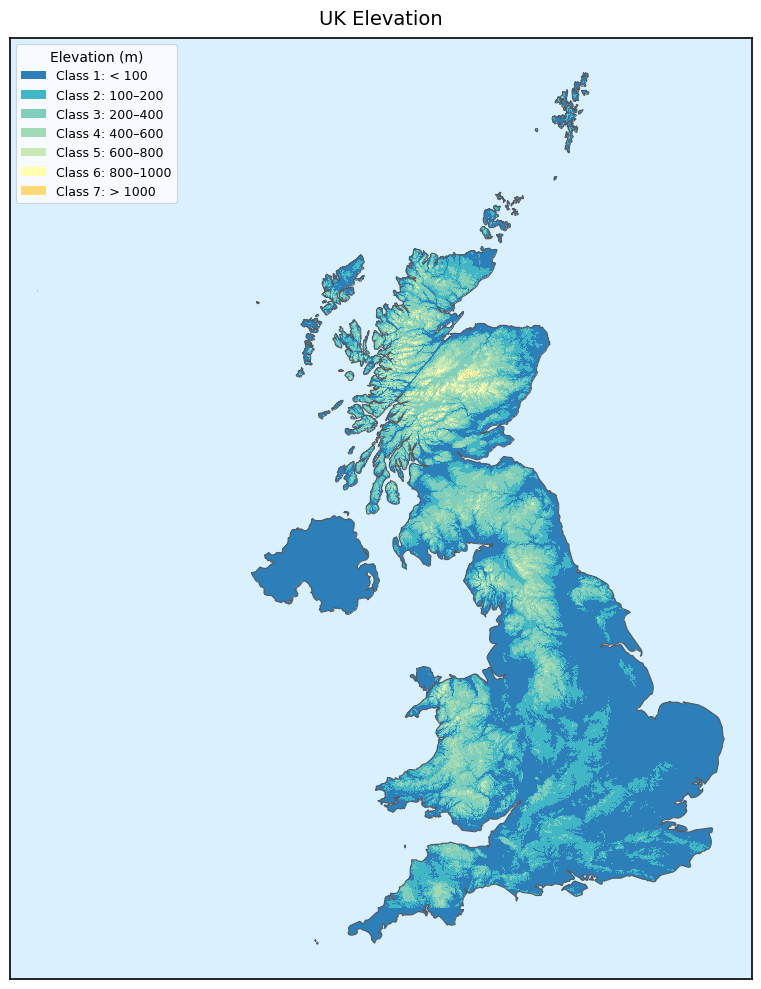

In [13]:
bins = [-np.inf, 100, 200, 400, 600, 800, 1000, np.inf]
labels = [
    "Class 1: < 100",
    "Class 2: 100–200",
    "Class 3: 200–400",
    "Class 4: 400–600",
    "Class 5: 600–800",
    "Class 6: 800–1000",
    "Class 7: > 1000",
]
colors = ["#2c7fb8", "#41b6c4", "#7fcdbb", "#a1dab4", "#c7e9b4", "#ffffb2", "#fed976"]

cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, cmap.N)

cmap2 = cmap.copy()
cmap2.set_bad((0, 0, 0, 0))
dem_class = dem_data.astype("float32").copy()

dem_class[(dem_class < -50) | (dem_class > 3000)] = np.nan

SEA_COLOR = "#d9f0ff"
fig, ax = plt.subplots(figsize=(8, 10))  
ax.set_facecolor(SEA_COLOR) 
show(
    dem_class,
    transform=mask_transform,
    ax=ax,
    cmap=cmap2,
    norm=norm,
    interpolation="nearest",
    zorder=1
)
uk.boundary.plot(ax=ax, color="0.35", linewidth=0.8, zorder=10)


minx, miny, maxx, maxy = uk.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)
ax.set_aspect("equal", adjustable="box")


ax.set_title("UK Elevation", fontsize=14, pad=10)
ax.set_xticks([])
ax.set_yticks([])

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
    spine.set_edgecolor("black")
    handles = [Patch(facecolor=colors[i], edgecolor="none", label=labels[i]) for i in range(len(labels))]
leg = ax.legend(
    handles=handles,
    title="Elevation (m)",
    loc="upper left",
    fontsize=9,
    title_fontsize=10)

leg.get_frame().set_edgecolor("#cccccc")
leg.get_frame().set_linewidth(0.8)

plt.tight_layout()
plt.show()
fig.savefig("UK Elevation.png", dpi=300, bbox_inches="tight")

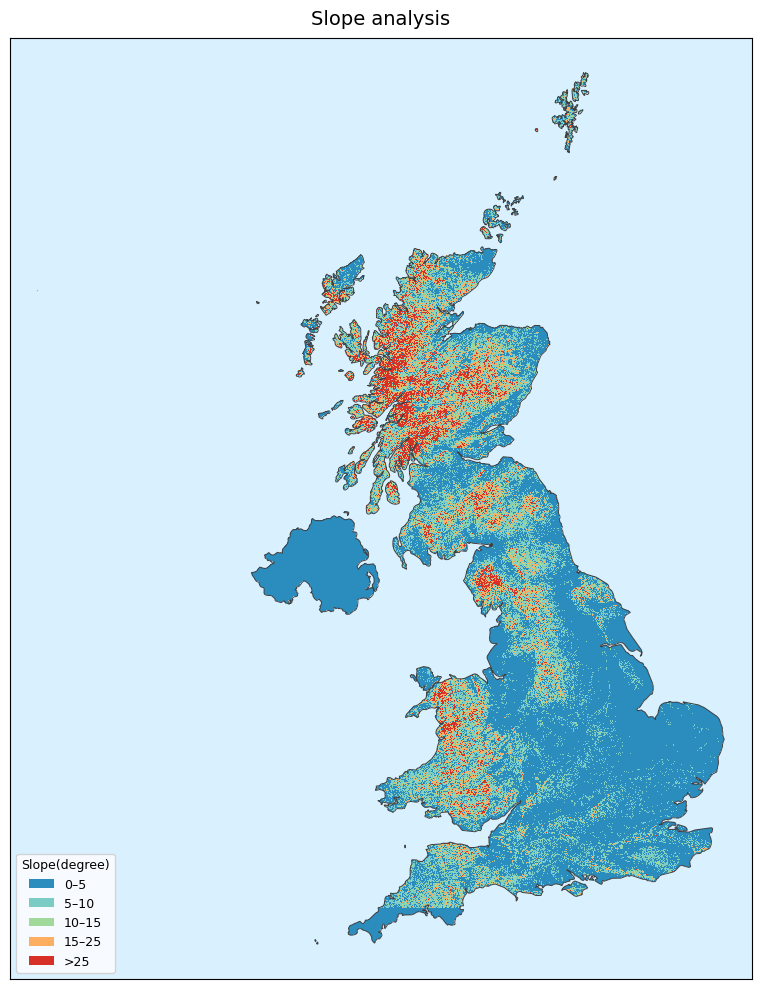

In [14]:
Z = dem_data.astype("float32").copy()
Z[(Z < -50) | (Z > 3000)] = np.nan

px = abs(mask_transform.a)   # x resolution (m)
py = abs(mask_transform.e)   # y resolution (m)

dZ_dy, dZ_dx = np.gradient(Z, py, px)
slope_pct = np.sqrt(dZ_dx**2 + dZ_dy**2) * 100.0
slope_pct[np.isnan(Z)] = np.nan

bins   = [0, 5, 10, 15, 25, np.inf]
labels = ["0–5","5–10","10–15","15–25",">25"]
colors = [
    "#2b8cbe",  # 0–5
    "#7bccc4",  # 5–10
    "#a1d99b",  # 10–15
    "#fdae61",  # 15–25
    "#d73027",  # >25
]
cmap2 = ListedColormap(colors)
cmap2.set_bad((0, 0, 0, 0))   
norm  = BoundaryNorm(bins, cmap2.N)

SEA_COLOR = "#d9f0ff"
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_facecolor(SEA_COLOR)

show(
    slope_pct,
    transform=mask_transform,
    ax=ax,
    cmap=cmap2,
    norm=norm,
    interpolation="nearest",
    zorder=1)

uk.boundary.plot(ax=ax, color="0.25", linewidth=0.7, zorder=10)
minx, miny, maxx, maxy = uk.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)

ax.set_aspect("equal", adjustable="box")

ax.set_title("Slope analysis", fontsize=14, pad=10)
ax.set_xticks([]); ax.set_yticks([])

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_edgecolor("black")

handles = [Patch(facecolor=colors[i], edgecolor="none", label=labels[i]) for i in range(len(labels))]
leg = ax.legend(
    handles=handles,
    title="Slope(degree)",
    loc="lower left",
    fontsize=9,
    title_fontsize=9)

leg.get_frame().set_edgecolor("#cccccc")
leg.get_frame().set_linewidth(1.0)

plt.tight_layout()
plt.show()
fig.savefig("Slope analysis.png", dpi=300, bbox_inches="tight")

In [15]:
Z = dem_data.astype("float32").copy()
Z[(Z < -50) | (Z > 3000)] = np.nan 

px = abs(mask_transform.a) 
py = abs(mask_transform.e) 

dZ_dy, dZ_dx = np.gradient(Z, py, px)
slope_pct = np.sqrt(dZ_dx**2 + dZ_dy**2) * 100.0
slope_pct[np.isnan(Z)] = np.nan

suit = np.full_like(slope_pct, np.nan, dtype="float32") 
suit[(slope_pct >= 0) & (slope_pct < 15)] = 1
suit[(slope_pct >= 15)] = 0

In [16]:
OUT_SLO_BIN = r"/Users/hester/Desktop/data/slo_binary.tif"

mask_meta = {
    "driver": "GTiff",
    "height": suit.shape[0],
    "width": suit.shape[1],
    "count": 1,
    "dtype": "uint8",
    "crs": raster_crs,            
    "transform": mask_transform,    
    "nodata": 255,
    "compress": "lzw"
}

suit_out = np.where(np.isnan(suit), 255, suit).astype("uint8")

with rasterio.open(OUT_SLO_BIN, "w", **mask_meta) as dst:
    dst.write(suit_out, 1)

print("Saved:", OUT_SLO_BIN)

Saved: /Users/hester/Desktop/data/slo_binary.tif


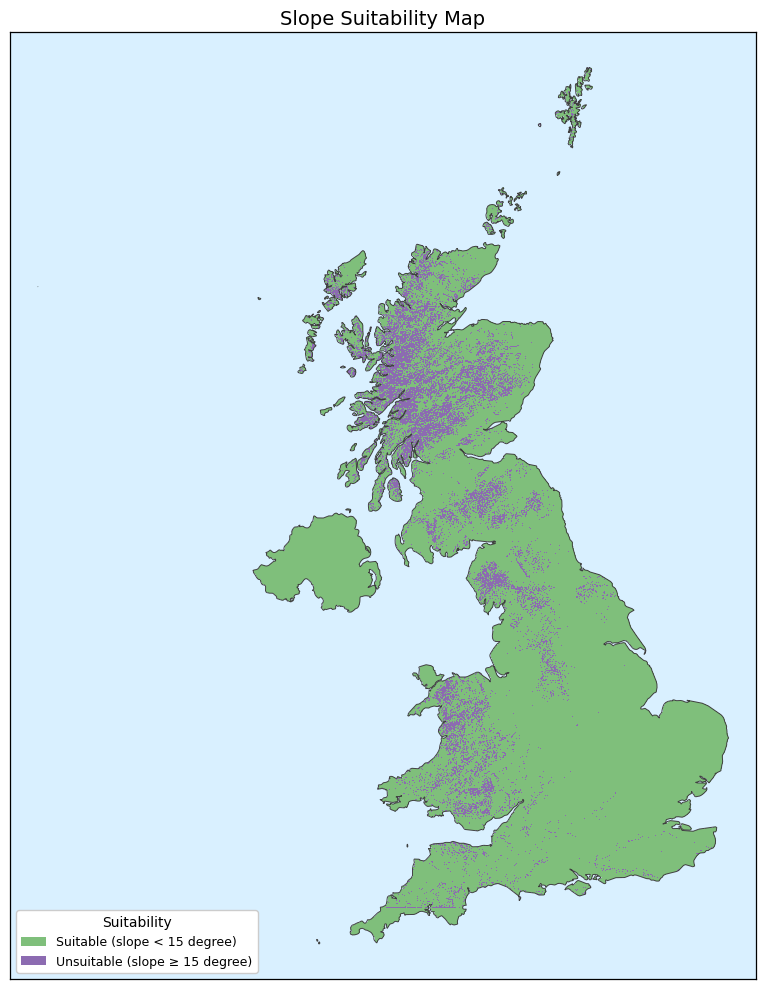

In [17]:
cmap = ListedColormap(["#8c6bb1", "#7fbf7b"])  
cmap.set_bad((0, 0, 0, 0))       
norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

SEA_COLOR = "#d9f0ff"
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_facecolor(SEA_COLOR)

show(
    suit,
    transform=mask_transform,
    ax=ax,
    cmap=cmap,
    norm=norm,
    interpolation="nearest",
    zorder=1
)

uk.boundary.plot(ax=ax, color="0.25", linewidth=0.7, zorder=10)

minx, miny, maxx, maxy = uk.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)
ax.set_aspect("equal", adjustable="box")

ax.set_title("Slope Suitability Map", fontsize=14)
ax.set_xticks([]); ax.set_yticks([])

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")

handles = [
    Patch(facecolor="#7fbf7b", edgecolor="none", label="Suitable (slope < 15 degree)"),
    Patch(facecolor="#8c6bb1", edgecolor="none", label="Unsuitable (slope ≥ 15 degree)"),
]
leg = ax.legend(handles=handles, title="Suitability", loc="lower left",
                fontsize=9, title_fontsize=10, frameon=True, framealpha=1.0)
leg.get_frame().set_edgecolor("#cccccc")
leg.get_frame().set_linewidth(1.0)

plt.tight_layout()
plt.show()
fig.savefig("Slope Suitability Map.png", dpi=300, bbox_inches="tight")